In [1]:
!pip install sentencepiece

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
%matplotlib inline

# 데이터 불러오기
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./submission.csv')

In [38]:
import warnings

# 경고 메시지를 무시하고 싶은 경우
warnings.filterwarnings('ignore', category=UserWarning, message="Creating a tensor from a list of numpy.ndarrays is extremely slow.*")

In [39]:
col = [
    'inquiry_type', #고객의 문의 유형
    'lead_desc_length', #고객이 작성한 Lead Description 길이
    'is_converted'
]

In [40]:
df_train = df_train[col]
df_test = df_test[col]

In [41]:
# True로 예측된 개수
num_true = sum(df_train['is_converted'] == 1)
print(f'Number of Total Train length: {len(df_train)}')
print(f"Number of True: {num_true}")
print(f'Number of Total Test length: {len(df_test)}')

Number of Total Train length: 59299
Number of True: 4850
Number of Total Test length: 5271


In [6]:
len(df_train['inquiry_type'])

59299

In [7]:
print(df_train['inquiry_type'].unique())
print(df_test['inquiry_type'].unique())

['Quotation or purchase consultation' 'Product Information'
 'Quotation or Purchase Consultation' 'Other'
 'Usage or technical consultation' 'Trainings' 'Services' 'Sales Inquiry'
 'Etc.' 'Technical Support' 'Usage or Technical Consultation'
 'Technical Consultation' 'Request for Partnership' nan 'sales'
 'technical' 'usage or technical consultation'
 'usage_or_technical_consultation' 'other'
 'quotation_or_purchase_consultation' 'other_' 'Request a Demo'
 'Request for Distributorship' 'Request for quotation or purchase'
 'Request for technical consulting' '(Select ID_Needs)' 'One Quick:Flex'
 'AIO' 'Needs' 'Purchase' 'technical_consultation' 'Customer Suggestions'
 'Event Inquiry' 'Others' 'OEM/ODM Request' 'Hospital TV' 'others'
 'i want to know the details about it' 'EDUCATIONAL EQUIPMENTS'
 'Digital platform' 'TV interactive' 'teach' 'Display Textbook and photos'
 'High inch 86 / 98 or 110' 'quotation_' 'Purchase or Quotation'
 'display product' 'first Info and pricing' 'Sales inqu

In [8]:
from transformers import pipeline
import pandas as pd
from tqdm.auto import tqdm
import torch
#from concurrent.futures import ThreadPoolExecutor, as_completed

In [9]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

# 텍스트 데이터 예시
texts_train = df_train['inquiry_type'].fillna("Unknown").tolist()  # 결측치 처리
texts_test = df_test['inquiry_type'].fillna("Unknown").tolist()  # 결측치 처리

Using cuda device


In [10]:
# 의도 카테고리 정의
intent_categories = [
    'Quotation or Purchase Consultation',  # 견적 또는 구매 상담
    'Product Information',  # 제품 정보
    'Technical Support',  # 기술 지원
    'Training',  # 교육 및 트레이닝
    'Services',  # 서비스
    'Sales Inquiry',  # 판매 문의
    'Partnership Request',  # 파트너쉽 요청
    'Demo Request',  # 데모 요청
    'Distributorship Request',  # 유통업체 요청
    'Customer Suggestions',  # 고객 제안
    'Event Inquiry',  # 이벤트 문의
    'Other',  # 기타
    'Media Inquiry',  # 미디어 문의
    'Educational Equipment',  # 교육 장비
    'Digital Platform',  # 디지털 플랫폼
    'Hospital TV',  # 병원 TV
    'LED Signage',  # LED 사이니지
    'Not Specified'  # 명시되지 않음
]

In [11]:
# 텍스트 데이터셋의 의도 분류 함수
def classify_intents(texts, classifier, categories):
    classified_intents = []
    for text in tqdm(texts, desc="Classifying intents"):
        # 분류 실행
        result = classifier(text, categories, multi_label=False)
        # 가장 가능성이 높은 카테고리 선택
        top_intent = result['labels'][0]
        classified_intents.append(top_intent)
    return classified_intents

In [13]:
# 훈련 데이터셋에 대한 의도 분류 (병렬 처리)
intents_train = classify_intents(texts_train, classifier, intent_categories)

Classifying intents:   0%|          | 0/59299 [00:00<?, ?it/s]

/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [15]:
# 테스트 데이터셋에 대한 의도 분류 (병렬 처리)
intents_test = classify_intents(texts_test, classifier, intent_categories)

Classifying intents:   0%|          | 0/5271 [00:00<?, ?it/s]

In [16]:
intents_train

['Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Product Information',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 'Quotation or Purchase Consultation',
 

In [42]:
df_train['inquiry_type'] = intents_train
df_test['inquiry_type'] = intents_test

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   inquiry_type      59299 non-null  object
 1   lead_desc_length  59299 non-null  int64 
 2   is_converted      59299 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 984.6+ KB


In [44]:
df_train['inquiry_type']

0        Quotation or Purchase Consultation
1        Quotation or Purchase Consultation
2                       Product Information
3        Quotation or Purchase Consultation
4        Quotation or Purchase Consultation
                        ...                
59294                   Product Information
59295                         Not Specified
59296                         Not Specified
59297    Quotation or Purchase Consultation
59298    Quotation or Purchase Consultation
Name: inquiry_type, Length: 59299, dtype: object

In [45]:
CII_df_train = df_train.drop('is_converted', axis = 1)
CII_df_test = df_test.drop('is_converted', axis = 1)

CII_df_train.to_csv('./preprocessing_data/CII(고객상호작용정보)_train.csv')
df_train['is_converted'].to_csv('./preprocessing_data/target_train.csv')
CII_df_test.to_csv('./preprocessing_data/CII(고객상호작용정보)_test.csv')
df_test['is_converted'].to_csv('./preprocessing_data/target_test.csv')

In [46]:
pd.read_csv('./preprocessing_data/CII(고객상호작용정보)_train.csv')

,Unnamed: 0,inquiry_type,lead_desc_length
0,0,Quotation or Purchase Consultation,62
1,1,Quotation or Purchase Consultation,96
2,2,Product Information,56
3,3,Quotation or Purchase Consultation,44
4,4,Quotation or Purchase Consultation,97
...,...,...,...
59294,59294,Product Information,200
59295,59295,Not Specified,70
59296,59296,Not Specified,34
59297,59297,Quotation or Purchase Consultation,377


In [47]:
pd.read_csv('./preprocessing_data/target_train.csv')

,Unnamed: 0,is_converted
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True
...,...,...
59294,59294,False
59295,59295,False
59296,59296,False
59297,59297,False


In [48]:
df_train = pd.read_csv('./preprocessing_data/CII(고객상호작용정보)_train.csv')
target_train = pd.read_csv('./preprocessing_data/target_train.csv')
df_train = pd.merge(df_train, target_train, on='Unnamed: 0', how='left')

df_test = pd.read_csv('./preprocessing_data/CII(고객상호작용정보)_test.csv')
target_test = pd.read_csv('./preprocessing_data/target_test.csv')
df_test = pd.merge(df_test, target_test, on='Unnamed: 0', how='left')

In [20]:
# df_train 데이터 프레임을 복사하여 새로운 데이터 프레임을 생성합니다.
df_train_transformed = df_train.copy()
df_test_transformed = df_test.copy()

# 'object' 타입 변수 목록을 가져옵니다.
object_columns = df_train_transformed.select_dtypes(include=['object']).columns

# 각 object 타입 변수에 대한 변환 비율을 저장하는 딕셔너리를 생성합니다.
conversion_rate_dict = {}

for column in object_columns:
    # 각 object 타입 변수에 대해 is_converted의 평균값을 계산합니다.
    conversion_rate = df_train_transformed.groupby(column)['is_converted'].mean()
    
    # 계산된 평균값을 딕셔너리에 저장합니다.
    conversion_rate_dict[column] = conversion_rate
    
    # 새로운 컬럼 이름을 설정합니다.
    new_column_name = f"{column}_conversion_rate"
    
    # 원본 데이터 프레임에 새로운 컬럼을 추가합니다. map 함수를 사용하여 각 행의 값에 대응하는 비율을 적용합니다.
    df_train_transformed[new_column_name] = df_train_transformed[column].map(conversion_rate)
    df_test_transformed[new_column_name] = df_test_transformed[column].map(conversion_rate_dict[column])

    # 테스트 데이터에 없는 카테고리의 경우 0 또는 평균값으로 처리합니다.
    df_test_transformed[new_column_name].fillna(df_test_transformed[new_column_name].mean(), inplace=True)

# 불필요한 컬럼을 제거합니다.
df_train = df_train_transformed.select_dtypes(include=['int64', 'float64', 'bool'])
df_test = df_test_transformed.select_dtypes(include=['int64', 'float64', 'bool'])

# 이제 df_train과 df_test는 변환된 특성을 포함하고 있습니다.

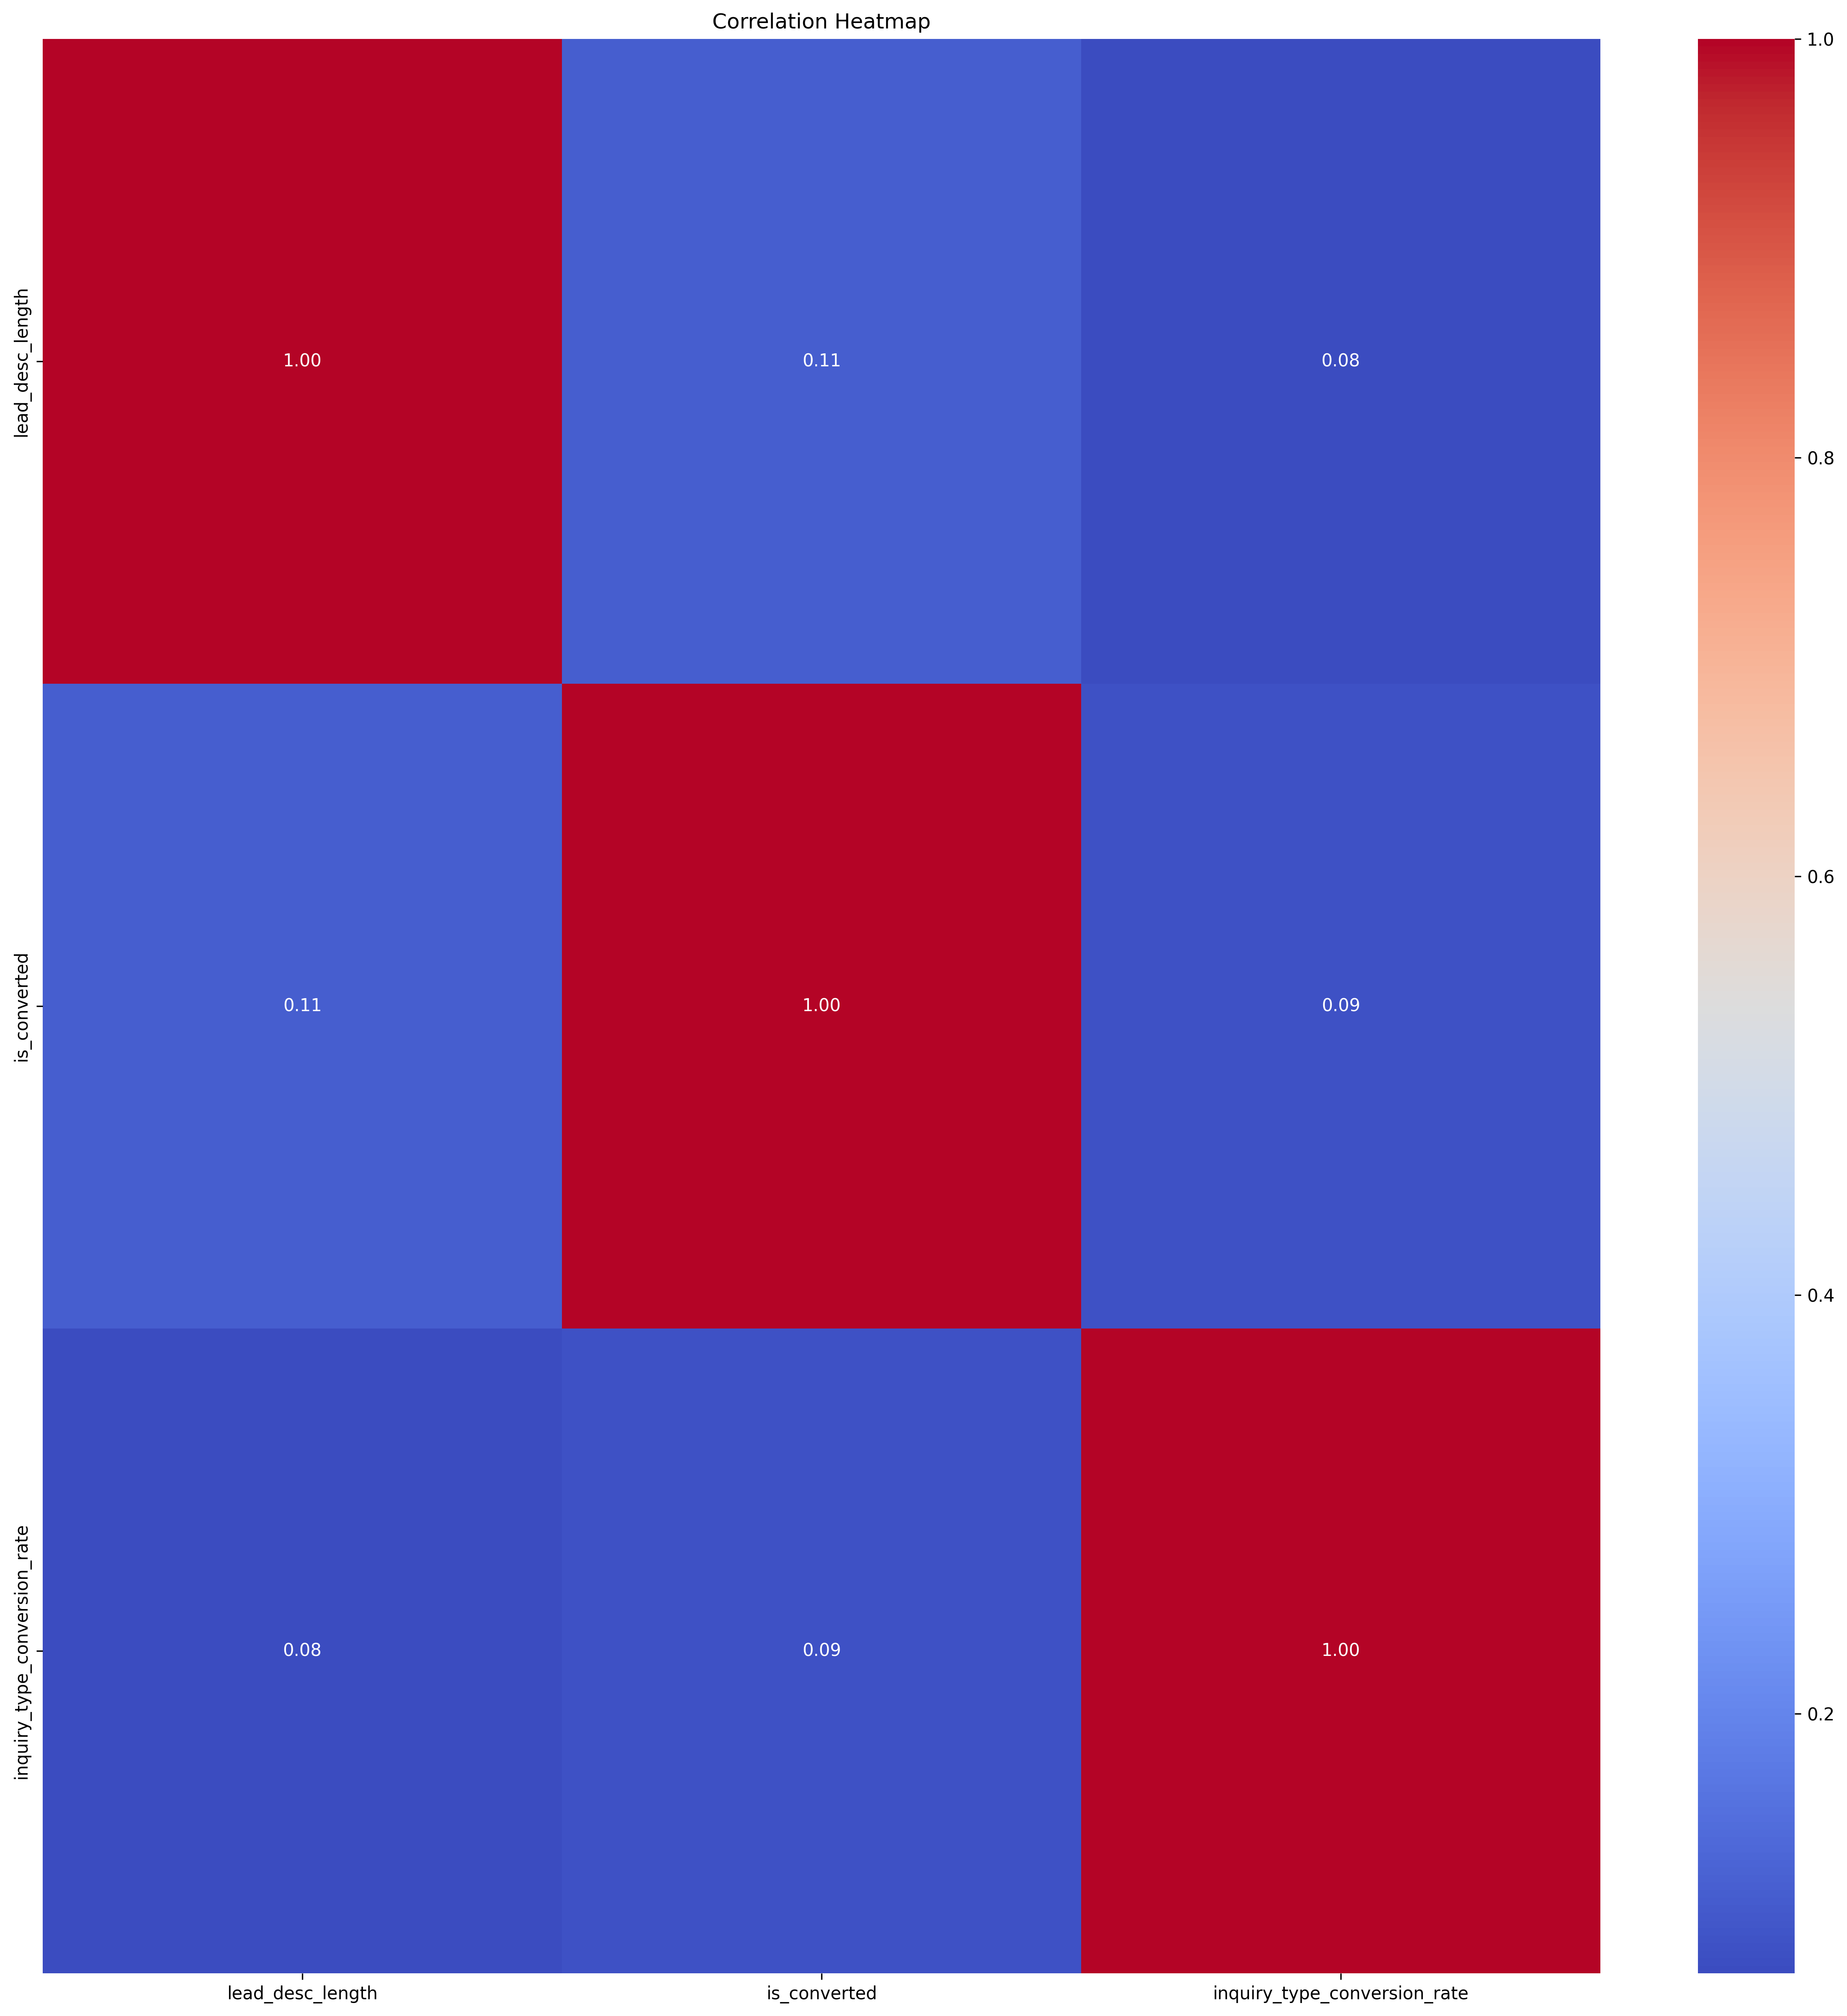

In [21]:
# 'is_converted'를 숫자형으로 변환 (True/False를 1/0으로)
df_train['is_converted'] = df_train['is_converted'].astype(int)

# 수치형 특성 선택
numerical_features = df_train.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist()

# 상관계수 계산
correlation_matrix = df_train[numerical_features].corr()

# 히트맵 생성
plt.figure(figsize=(20, 20), dpi = 300)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
#plt.savefig('./corr.png') 

In [22]:
from pycaret.classification import *
clf = setup(data=df_train, 
            target='is_converted', 
            session_id=404, 
            use_gpu=True, 
            #normalize=True,  # 데이터 정규화
            #normalize_method='minmax',  # 정규화 방법
            #feature_selection=True,  # 특성 선택
            #remove_multicollinearity=True,  # 다중공선성 제거
            #categorical_imputation='lightgbm',  # 범주형 변수 결측치는 최빈값으로 대체
            #imputation_type='iterative',  # 반복적인(imputation) 방식 사용
            #categorical_features = col[:-1],
            verbose=True,
           )

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,404
1,Target,is_converted
2,Target type,Binary
3,Original data shape,"(59299, 3)"
4,Transformed data shape,"(59299, 3)"
5,Transformed train set shape,"(41509, 3)"
6,Transformed test set shape,"(17790, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [23]:
# 모델 비교
best_model = compare_models(sort='F1', cross_validation=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:19:53
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.8500,0.0000,0.1357,0.1605,0.0600,0.0271,0.0415,0.0680
nb,Naive Bayes,0.9037,0.6672,0.0315,0.1313,0.0507,0.0197,0.0255,0.0150
qda,Quadratic Discriminant Analysis,0.9038,0.6667,0.0300,0.1283,0.0485,0.0179,0.0234,0.0240
rf,Random Forest Classifier,0.9131,0.6456,0.0186,0.1890,0.0337,0.0193,0.0350,0.2340
knn,K Neighbors Classifier,0.9115,0.5732,0.0183,0.1500,0.0324,0.0155,0.0253,0.2500
et,Extra Trees Classifier,0.9144,0.6385,0.0174,0.2157,0.0321,0.0201,0.0396,0.2150
dt,Decision Tree Classifier,0.9142,0.6371,0.0171,0.2075,0.0315,0.0192,0.0376,0.0220
lda,Linear Discriminant Analysis,0.9149,0.6690,0.0059,0.1074,0.0111,0.0030,0.0067,0.0270
xgboost,Extreme Gradient Boosting,0.9179,0.6910,0.0009,0.1000,0.0018,0.0009,0.0042,0.8040
gbc,Gradient Boosting Classifier,0.9182,0.6988,0.0006,0.2000,0.0012,0.0010,0.0095,0.5250


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

KeyboardInterrupt: 